# 05 Decision Algorithm to simulate Buy/Sell

In [434]:
import plot_helper as ph
from pandas.tseries.offsets import DateOffset
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [8]:
import data_prep_helper
do_big = data_prep_helper.ModelData(chart_col=["Price", "High", "Low", "Price_norm"])


Using TensorFlow backend.


In [18]:
dates = do_big.get_forecast_dates()

In [268]:

growth_list = []
for curr_day in dates[30:]:
    day_dict = {}
    ari_forecast = do_big.ari_forecast(curr_day, shift=-31)
    ari_df = ari_forecast.predicted_mean
    ari_df.index = ari_df.index + DateOffset(31)
    
    gru_df = do_big.gru_forecast(curr_day, shift=-31)
    real_price, real_30 = do_big.get_real_price(curr_day, shift=-31)
    
    curr_date = datetime.strptime(curr_day, "%Y-%m-%d")
    future_offset = curr_date + DateOffset(31)
    
    past_offset = curr_date + DateOffset(-10)

    
    ari_future = ari_df[(ari_df.index < future_offset) & (ari_df.index >= curr_date)].iloc[-25:].rolling(window=5, min_periods=1).mean()
    ari_growth = np.round(100 - ((ari_future[0]/ari_future[-1])*100),2)
    day_dict["ari_growth"] = ari_growth
    gru_future = gru_df[(gru_df.index < future_offset) & (gru_df.index >= curr_date)].iloc[-25:].rolling(window=5, min_periods=1).mean()
    gru_growth = np.round(100 - ((gru_future.values[0]/gru_future.values[-1])*100),2)[0]
    day_dict["gru_growth"] = gru_growth
    #real_future = real_30.iloc[-15:,:].rolling(window=5, min_periods=1).mean()
    #real_growth = np.round(100 - ((real_future.values[0]/real_future.values[-1])*100),2)[0]
    #day_dict["real_growth"] = real_growth
    
    real_past = real_price[real_price.index > past_offset].rolling(window=5, min_periods=1).mean()
    real_past = np.round(100 - ((real_past.values[0]/real_past.values[-1])*100),2)[0]
    day_dict["real_past"] = real_past

    growth_list.append(day_dict)


In [269]:
growth_dict = pd.DataFrame(growth_list, index=ari_df.index[30:-30])

In [270]:
growth_dict["comb_pred"] = (growth_dict["ari_growth"] + growth_dict["gru_growth"]) / 2

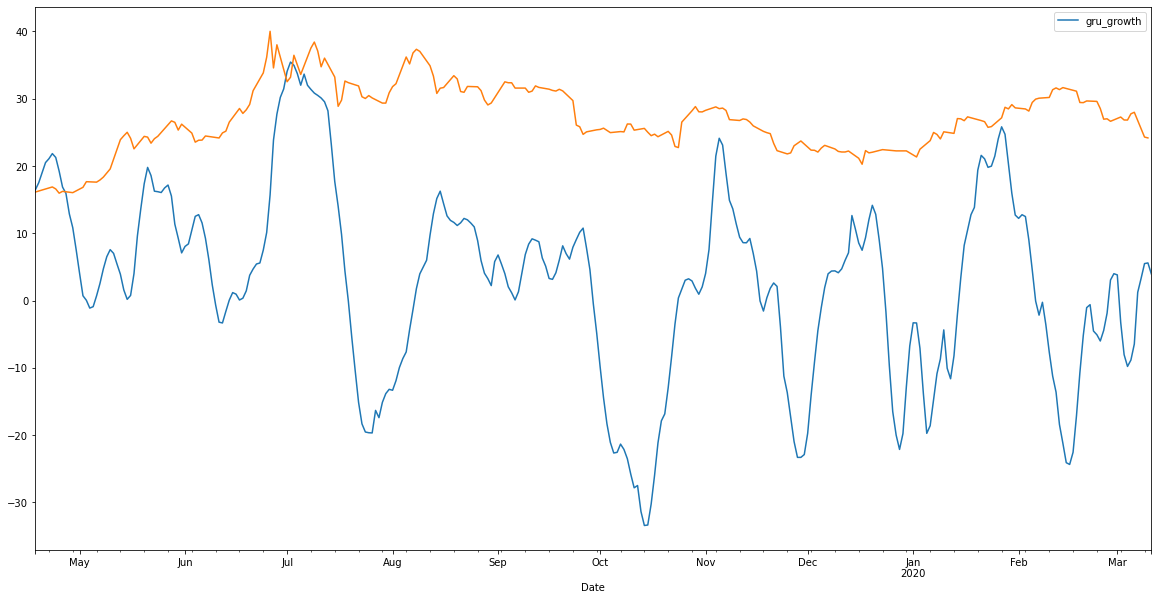

In [279]:
growth_dict[["gru_growth"]].plot(figsize=(20,10))
(((real_price["bitcoin_Price"].iloc[30:]*10)/real_price["bitcoin_Price"].iloc[30:].max())*4).plot()

In [263]:
from scipy.signal import argrelextrema

In [229]:
gru_gro = growth_dict[["gru_growth"]]

In [230]:
gru_gro.head()

,gru_growth
2019-04-18,15.77
2019-04-19,15.99
2019-04-20,17.32
2019-04-21,19.14
2019-04-22,20.77


In [430]:
n=1 # number of points to be checked before and after 
# Find local peaks

min_val = argrelextrema(gru_gro.gru_growth.values, np.less_equal, order=n)[0]
max_val = argrelextrema(gru_gro.gru_growth.values, np.greater_equal, order=n)[0]

min_val = [x+n for x in min_val]
max_val = [x+n for x in max_val]


gru_gro['min'] = gru_gro.iloc[min_val[:-1]]['gru_growth']
gru_gro['max'] = gru_gro.iloc[max_val[:-1]]['gru_growth']



In [432]:
#gru_gro['min'][gru_gro['min'] > 0] = np.nan
gru_gro['max'][gru_gro['max'] < 0] = np.nan


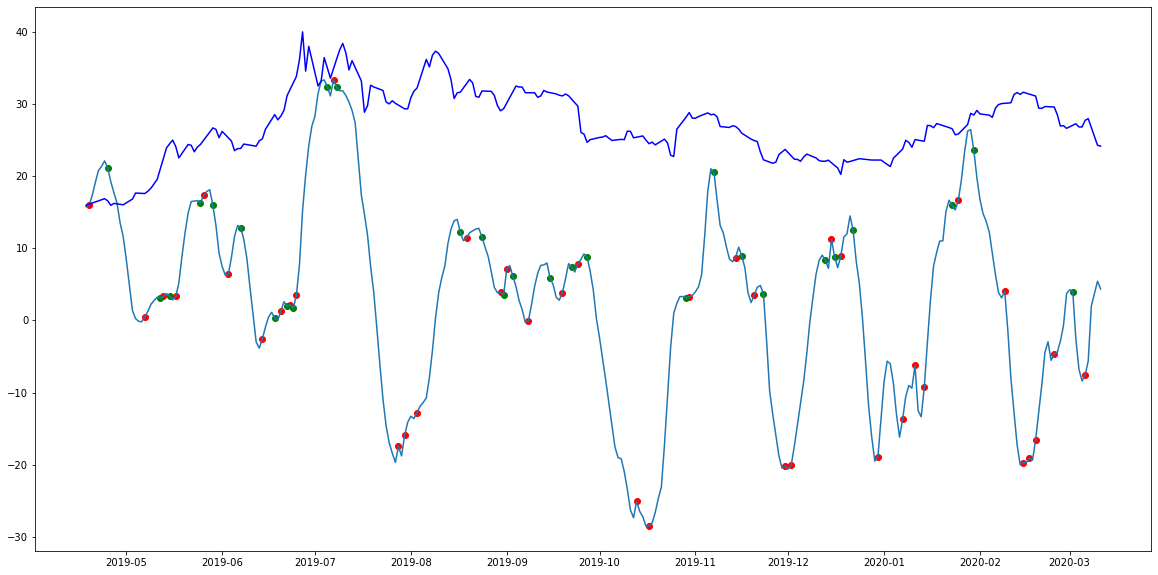

In [435]:
# Plot results

fig = plt.figure(figsize=(20,10))

plt.scatter(gru_gro.index, gru_gro['min'], c='r')
plt.scatter(gru_gro.index, gru_gro['max'], c='g')
plt.plot(gru_gro.index, gru_gro['gru_growth'])
plt.plot(gru_gro.index,((real_price["bitcoin_Price"].iloc[29:]*10)/real_price["bitcoin_Price"].iloc[29:].max())*4, c='b')
plt.plot(figsize=(20,10))
plt.show()

In [460]:
budget = 100000
init_val = budget
last_sell_val = budget
last_sell_max = np.nan
last_buy_min = np.nan
bitcoin = 0
min_mem = []
max_mem = []
start=0


last_status = "sell"

for curr_day in dates[31:]:
    curr_price = float(real_price[real_price.index == curr_day]["bitcoin_Price"])
    
    ### BUYING
    min_val = float(gru_gro[gru_gro.index == curr_day]["min"].values)
    if np.isfinite(min_val) and (last_status == "sell"):
        last_buy_min = min_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        if (dist>3) or (start==0):
            print("BUY_DISTANCE: {}".format(dist))
            start=1
            bitcoin = budget/curr_price
            budget = 0
            last_status = "buy"

            print("{}: Buy Bitcoin for {}\n\tNow having {} Bitcoin\n".format(curr_day, curr_price, bitcoin))

    ### SELLING
    max_val = float(gru_gro[gru_gro.index == curr_day]["max"].values)
    if np.isfinite(max_val) and (last_status == "buy"):
        last_sell_max = max_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        if (dist>3):
            print("SELL_DISTANCE: {}".format(dist))
            budget = bitcoin*curr_price
            bitcoin = 0
            last_status = "sell"
            if budget < last_sell_val:
                result_marker = "[-]"
            else:
                result_marker = "[+]"
            last_sell_val = budget
            print("{} {}: Sell Bitcoin for {}\n\tNow having {} Dollar\n".format(result_marker ,curr_day, curr_price, budget))



BUY_DISTANCE: nan
2019-04-19: Buy Bitcoin for 5314.08
	Now having 18.817932737181224 Bitcoin

SELL_DISTANCE: 5.17
[-] 2019-04-25: Sell Bitcoin for 5209.1
	Now having 98024.49342125072 Dollar

BUY_DISTANCE: 20.65
2019-05-07: Buy Bitcoin for 5849.5
	Now having 16.757755948585473 Bitcoin

SELL_DISTANCE: 15.78
[+] 2019-05-25: Sell Bitcoin for 8156.65
	Now having 136687.15005802969 Dollar

BUY_DISTANCE: 9.87
2019-06-03: Buy Bitcoin for 8124.8
	Now having 16.82344796893827 Bitcoin

SELL_DISTANCE: 6.43
[-] 2019-06-07: Sell Bitcoin for 7985.2
	Now having 134338.59672156587 Dollar

BUY_DISTANCE: 10.29
2019-06-14: Buy Bitcoin for 8656.1
	Now having 15.51952920155334 Bitcoin

SELL_DISTANCE: 29.860000000000003
[+] 2019-07-05: Sell Bitcoin for 10970.2
	Now having 170252.33924688047 Dollar

BUY_DISTANCE: 14.940000000000001
2019-07-28: Buy Bitcoin for 9664.266666666666
	Now having 17.61668475416798 Bitcoin

SELL_DISTANCE: 5.26
[+] 2019-08-17: Sell Bitcoin for 10527.300000000001
	Now having 185456.125

In [589]:
budget = 100000
bitcoin = 0

last_sell_val = budget
last_sell_max = np.nan
last_buy_min = np.nan
min_mem = []
max_mem = []
min_val_arr_last = 0
max_val_arr_last = 0
start=0

grow_vals = []

last_status = "sell"

n=1
dist_val=5
last_bitcoin_price=0

result_list = []

for curr_day in dates[5:]:
    result_dict = {}
    curr_date = datetime.strptime(curr_day, "%Y-%m-%d")
    result_dict["date"] = curr_date
    future_offset = curr_date + DateOffset(31)
    
    real_price, _ = do_big.get_real_price(curr_day)
    curr_price = float(real_price[real_price.index == curr_day]["bitcoin_Price"])
    result_dict["curr_price"] = curr_price
    
    gru_df = do_big.gru_forecast(curr_day, shift=-31)
    gru_future = gru_df[(gru_df.index < future_offset) & (gru_df.index >= curr_date)].iloc[-25:].rolling(window=12, min_periods=1).mean()
    gru_growth = np.round(100 - ((gru_future.values[0]/gru_future.values[-1])*100),2)[0]
    grow_vals.append(gru_growth)
    result_dict["gru_growth"] = gru_growth
    
    min_val_arr = argrelextrema(np.array(grow_vals), np.less_equal, order=n)[0]
    min_val_arr_len = len(min_val_arr)
    
    max_val_arr = argrelextrema(np.array(grow_vals), np.greater, order=n)[0]
    max_val_arr_len = len(max_val_arr)
    
    min_val = np.nan
    max_val = np.nan
    
    if (min_val_arr_len > min_val_arr_last):
        min_val = grow_vals[min_val_arr[-1]]
        min_val_arr_last = min_val_arr_len
    
    if (max_val_arr_len > max_val_arr_last):
        max_val = grow_vals[max_val_arr[-1]]
        max_val_arr_last = max_val_arr_last
        
    if (max_val < 0):
        max_val = np.nan

    ### BUYING
    if np.isfinite(min_val) and (last_status == "sell"):
        last_buy_min = min_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        if (dist>dist_val) or (start==0):
            if (min_val < last_sell_max) or (start==0):
                result_dict["buy_trigger"] = min_val
                result_dict["buy_price"] = curr_price
                start=1
                print("BUY_DISTANCE: {}".format(dist))
                bitcoin = budget/curr_price
                budget = 0
                last_status = "buy"

                print("{}: Buy Bitcoin for {}\n\tNow having {} Bitcoin\n".format(curr_day, curr_price, bitcoin))

    ### SELLING
    if np.isfinite(max_val) and (last_status == "buy"):
        last_sell_max = max_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        if (dist>dist_val):
            result_dict["sell_trigger"] = max_val
            result_dict["sell_price"] = curr_price
            print("SELL_DISTANCE: {}".format(dist))
            budget = bitcoin*curr_price
            bitcoin = 0
            last_status = "sell"
            if budget < last_sell_val:
                result_marker = "[-]"
            else:
                result_marker = "[+]"
            last_sell_val = budget
            print("{} {}: Sell Bitcoin for {}\n\tNow having {} Dollar\n".format(result_marker ,curr_day, curr_price, budget))

    
    result_dict["budget"] = budget
    result_dict["bitcoin"] = bitcoin
    
    result_list.append(result_dict)

BUY_DISTANCE: nan
2019-03-23: Buy Bitcoin for 3972.6
	Now having 25.172431153400797 Bitcoin

SELL_DISTANCE: 21.35
[+] 2019-04-23: Sell Bitcoin for 5511.6
	Now having 138740.37154508385 Dollar

BUY_DISTANCE: 20.16
2019-05-10: Buy Bitcoin for 6386.0
	Now having 21.725708040257416 Bitcoin

SELL_DISTANCE: 14.22
[+] 2019-05-21: Sell Bitcoin for 7930.3
	Now having 172291.3824716534 Dollar

BUY_DISTANCE: 15.1
2019-06-16: Buy Bitcoin for 9097.9
	Now having 18.937489142731113 Bitcoin

SELL_DISTANCE: 30.43
[+] 2019-07-03: Sell Bitcoin for 11900.8
	Now having 225371.2707898144 Dollar

BUY_DISTANCE: 12.639999999999997
2019-07-27: Buy Bitcoin for 9747.633333333333
	Now having 23.120614315592615 Bitcoin

SELL_DISTANCE: 5.820000000000002
[+] 2019-08-22: Sell Bitcoin for 10105.0
	Now having 233633.80765906337 Dollar

BUY_DISTANCE: 9.2
2019-08-29: Buy Bitcoin for 9491.0
	Now having 24.61635314077161 Bitcoin

SELL_DISTANCE: 5.16
[+] 2019-09-01: Sell Bitcoin for 10098.849999999999
	Now having 248596.8579

In [584]:
sim_result = pd.DataFrame(result_list).set_index("date")

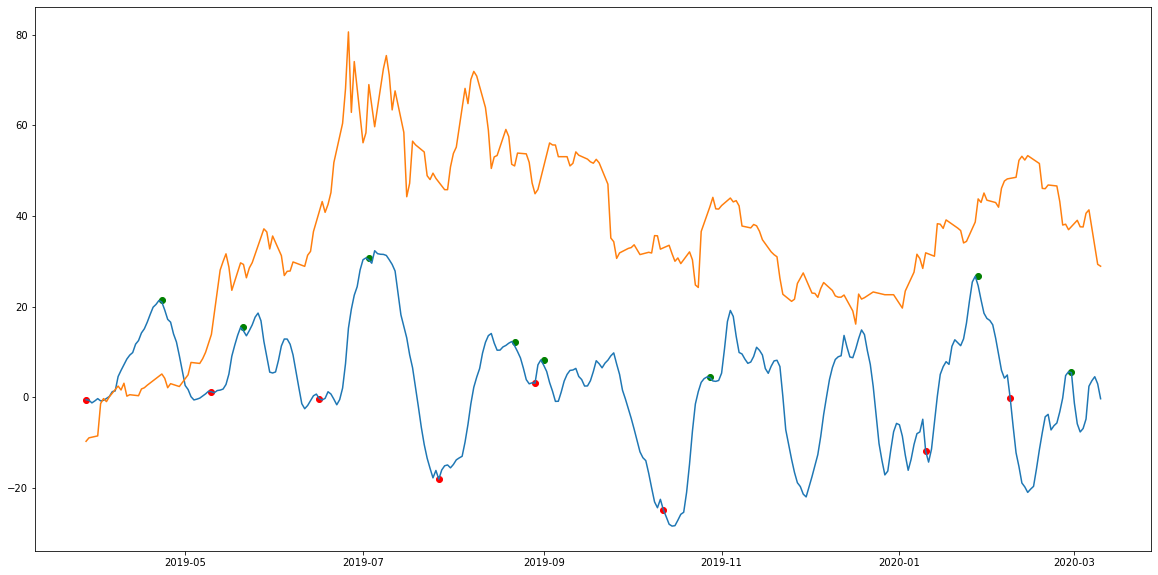

In [585]:
fig = plt.figure(figsize=(20,10))


plt.scatter(sim_result.index,sim_result["buy_trigger"], c="r")
plt.scatter(sim_result.index,sim_result["sell_trigger"], c="g")
plt.plot(sim_result.index, sim_result["gru_growth"])
plt.plot(sim_result.index, ((sim_result["curr_price"]*10)/1000)-50)